In [21]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
# ignores FutureWarnings. Helps in readbility.
# Since we are using a conda envrionment with defined package versions we are not concerned with changes in a package's future releases.


In [23]:
datadir = "data"
savedir = "plots"

if not os.path.exists(savedir):
    os.mkdir(savedir)

In [24]:
# paths to results
methods = ["MuSiC", "CibersortX", "Scaden", "TAPE-O", "TAPE-A", "Linear MLPs", "BayesPrism", "BayesPrism-M", "DISSECT"]
results = [os.path.join(datadir, f"{method.replace(' ', '_')}.csv") for method in methods]
results_dict = dict(zip(methods, results))

In [25]:
# read results
df_results_dict = {}

df_meta = pd.read_table(os.path.join(datadir, "metadata.txt"), index_col=0) # read metadata
for method in results_dict.keys():
    df = pd.read_table(results_dict[method], index_col=0)
    df_results_dict[method] = df
    common = list(set(df_meta["projid.x"].tolist())&set(df_results_dict[method].index.tolist()))
    
    df_results_dict[method] = df_results_dict[method].loc[common,:]
    df_meta.index = df_meta["projid.x"].tolist()
    df_meta = df_meta.loc[common,:]

    df_results_dict[method]["brc"] = df_meta["braaksc"].copy()

# 3A

In [26]:
# read IHC data

ihc_path = datadir
ihcs = [file for file in os.listdir(ihc_path) if "IHC." in file and "txt" in file]

for file in ihcs:
    if file==ihcs[0]:
        df_ihc = pd.read_table(os.path.join(ihc_path, file)).T
        df_ihc.columns=[file.split(".")[1].capitalize()]
        
    else:
        tmp = pd.read_table(os.path.join(ihc_path, file)).T
        tmp.columns=[file.split(".")[1].capitalize()]
        
        df_ihc = pd.concat([df_ihc, tmp], axis=1)
df_ihc = df_ihc.dropna()

In [27]:
common = list(set(df_ihc.index.tolist())&set(df_results_dict["Scaden"].index.astype(str).tolist()))
# get samples that are measured with IHC
df_ihc = df_ihc.loc[common]


In [28]:
# Harmonize cell type names between IHC and results
df_ihc.rename(columns={"Oligo": "Oligodendrocyte",
                      "Astro": "Astrocyte",
                      "Endo": "Endothelial",
                      "Neuro": "Neuron"}, inplace=True)

In [29]:
# compute jsd
from scipy.spatial.distance import jensenshannon as jsd

df_jsd = pd.DataFrame(index=list(df_results_dict.keys()), columns=df_ihc.index)
for key in df_results_dict:
    df_results_dict[key].index = df_results_dict[key].index.astype(str)
    df_results_dict[key] = df_results_dict[key].loc[common]
    df_results_dict[key]["Neuron"] = df_results_dict[key]["Excitatory"] + df_results_dict[key]["Inhibitory"] # IHC includes only Neuron
    df_results_dict[key] = df_results_dict[key][df_ihc.columns]
    df_results_dict[key] = df_results_dict[key].div(df_results_dict[key].sum(1),0) # For evaluation, normalize fractions to sum to 1 over cell types present in IHC.
    
    for sample in df_ihc.index:
        x, y = df_ihc.T[sample].tolist(), df_results_dict[key].T[sample].tolist()
        df_jsd.loc[key, sample] = jsd(x, y)

In [30]:
df_jsd = df_jsd.loc[[idx for idx in df_jsd.index if "Linear" not in idx]]

In [31]:
df_jsd = df_jsd.T

In [32]:
palette = sns.color_palette("colorblind", len(df_jsd.columns)+1)
colors = palette.as_hex()

In [33]:
colors

['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133']

In [34]:
print(colors)

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133']


In [35]:
colors = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ece133', '#949494', '#fbafe4'] # #ece133 is added for BayesPrism
palette = dict(zip(df_jsd.columns.tolist(), colors))

In [36]:
palette

{'MuSiC': '#0173b2',
 'CibersortX': '#de8f05',
 'Scaden': '#029e73',
 'TAPE-O': '#d55e00',
 'TAPE-A': '#cc78bc',
 'BayesPrism': '#ece133',
 'BayesPrism-M': '#949494',
 'DISSECT': '#fbafe4'}

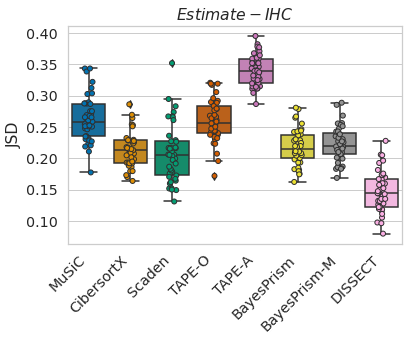

In [37]:
sns.set(style="whitegrid", font_scale=1.3)
pd.DataFrame.iteritems = pd.DataFrame.items
sns.boxplot(data=df_jsd, palette=palette)
sns.stripplot(data=df_jsd, palette=palette, edgecolor="gray",
                 linewidth=1)
plt.xticks(rotation=45, ha="right")
plt.ylabel("JSD")

plt.title(r"${}$".format("Estimate-IHC"))
plt.savefig(os.path.join(savedir, "3Aleft_jsd.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(savedir, "3Aleft_jsd.png"), bbox_inches="tight", dpi=300)
plt.show()

# Exc to inh ratio

In [38]:
df_results_dict = {}

df_meta = pd.read_table(os.path.join(datadir, "metadata.txt"), index_col=0)
for method in results_dict.keys():
    df = pd.read_table(results_dict[method], index_col=0)
    df_results_dict[method] = df
    common = list(set(df_meta["projid.x"].tolist())&set(df_results_dict[method].index.tolist()))
    
    df_results_dict[method] = df_results_dict[method].loc[common,:]
    df_meta.index = df_meta["projid.x"].tolist()
    df_meta = df_meta.loc[common,:]

    df_results_dict[method]["brc"] = df_meta["braaksc"].copy()

In [39]:
for method in df_results_dict:
    df_results_dict[method]["Exc/Inh"] = df_results_dict[method]["Excitatory"]/df_results_dict[method]["Inhibitory"]

In [40]:
df_exc_inh = pd.DataFrame(index=df_results_dict["MuSiC"].index, columns=methods)

for idx in df_exc_inh.index:
    for col in df_exc_inh.columns:
        df_exc_inh.loc[idx, col] = df_results_dict[col].loc[idx, "Exc/Inh"]

In [41]:
from copy import deepcopy
color_palette = deepcopy(palette)
color_palette["Linear MLPs"] = '#ca9161'

In [42]:
sns.set(style="whitegrid", font_scale=1.3)

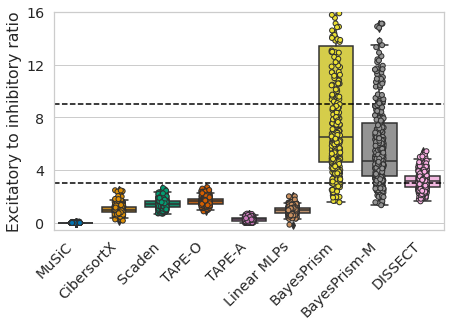

In [43]:
plt.figure(figsize=(7,4))
ax=sns.boxplot(data=df_exc_inh, palette=color_palette)
sns.stripplot(data=df_exc_inh, palette=color_palette, dodge=True, edgecolor="gray",
                 linewidth=1,ax=ax)

#plt.yticks(np.arange(0, df_exc_inh.max().max()+1, 1.0))
plt.xticks(rotation=45, ha="right")

ax.set_ylim(-0.5,16)
plt.yticks(np.arange(0, 20, 4))

plt.axhline(y=3, linestyle="--", color="black")
plt.axhline(y=9, linestyle="--", color="black")

plt.ylabel("Excitatory to inhibitory ratio")
plt.savefig(os.path.join(savedir, "3Aright_exc_inh.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(savedir, "3Aright_exc_inh.png"), bbox_inches="tight", dpi=300)
plt.show()

# 3B

In [44]:
df_results_dict = {}

df_meta = pd.read_table(os.path.join(datadir, "metadata.txt"), index_col=0)
for method in results_dict.keys():
    df = pd.read_table(results_dict[method], index_col=0)
    df_results_dict[method] = df
    common = list(set(df_meta["projid.x"].tolist())&set(df_results_dict[method].index.tolist()))
    
    df_results_dict[method] = df_results_dict[method].loc[common,:]
    df_meta.index = df_meta["projid.x"].tolist()
    df_meta = df_meta.loc[common,:]

    df_results_dict[method]["brc"] = df_meta["braaksc"].copy()

In [45]:
mic_ihc = pd.read_table(os.path.join(datadir, "IHC.microglia.txt"))


In [46]:
df_mic = pd.DataFrame(index=df_results_dict["MuSiC"].index, columns=methods)

for idx in df_mic.index:
    for col in df_mic.columns:
        df_mic.loc[idx, col] = df_results_dict[col].loc[idx, "Microglia"]

In [47]:
sns.set(style="whitegrid", font_scale=1.3)

In [48]:
mic_ihc = mic_ihc.T

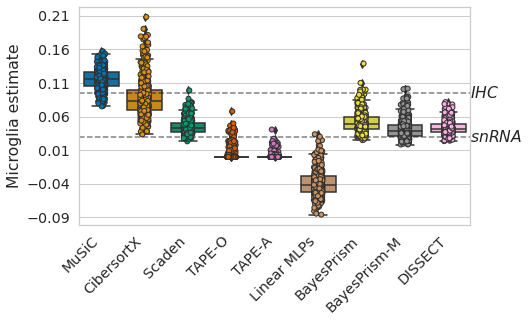

In [49]:
plt.figure(figsize=(7,4))
ax=sns.boxplot(data=df_mic, palette=color_palette)
sns.stripplot(data=df_mic, palette=color_palette, dodge=False, edgecolor="gray",
                 linewidth=1)

range_ = [round(val, 2) for val in np.arange(df_mic.min().min(), df_mic.max().max()+0.05, 0.05)]

plt.yticks(range_)
plt.xticks(rotation=45, ha="right")
sc_val = 0.03 # rounded value
plt.axhline(y=mic_ihc.median()[0], linestyle="--", color="black", alpha=0.5)
plt.text(x=df_mic.shape[1]-0.5,y=mic_ihc.median()[0], s=r"$IHC$", va="center")
plt.axhline(y=sc_val, linestyle="--", color="black", alpha=0.5)
plt.text(x=df_mic.shape[1]-0.5,y=sc_val, s=r"$snRNA$", va="center")

plt.ylabel("Microglia estimate")
plt.savefig(os.path.join(savedir, "3B_mic_extended.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(savedir, "3B_mic_extended.png"), bbox_inches="tight", dpi=300)
plt.show()

# 3C

In [50]:
df_results_dict = {}

df_meta = pd.read_table(os.path.join(datadir, "metadata.txt"), index_col=0)
for method in results_dict.keys():
    df = pd.read_table(results_dict[method], index_col=0)
    df_results_dict[method] = df
    common = list(set(df_meta["projid.x"].tolist())&set(df_results_dict[method].index.tolist()))
    
    df_results_dict[method] = df_results_dict[method].loc[common,:]
    df_meta.index = df_meta["projid.x"].tolist()
    df_meta = df_meta.loc[common,:]

    df_results_dict[method]["brc"] = df_meta["braaksc"].copy()

In [51]:
ihcs = [file for file in os.listdir(ihc_path) if "IHC." in file and "txt" in file]

In [52]:
for file in ihcs:
    if file==ihcs[0]:
        df_ihc = pd.read_table(os.path.join(ihc_path, file)).T
        df_ihc.columns=[file.split(".")[1].capitalize()]
        
    else:
        tmp = pd.read_table(os.path.join(ihc_path, file)).T
        tmp.columns=[file.split(".")[1].capitalize()]
        
        df_ihc = pd.concat([df_ihc, tmp], axis=1)
df_ihc = df_ihc.dropna()

In [53]:
common = list(set(df_ihc.index.tolist())&set(df_results_dict["Scaden"].index.astype(str).tolist()))


In [54]:
df_ihc = df_ihc.div(df_ihc.sum(1), 0)

# Harmonize cell type names between IHC and results
df_ihc.rename(columns={"Oligo": "Oligodendrocyte",
                      "Astro": "Astrocyte",
                      "Endo": "Endothelial",
                      "Neuro": "Neuron"}, inplace=True)

In [55]:
palette = sns.color_palette("colorblind", len(list(df_results_dict.keys())))
colors = palette.as_hex()

In [56]:
from scipy.spatial.distance import jensenshannon as jsd
palette = dict(zip(list(df_results_dict.keys()), colors))

In [57]:
colors_dict = dict(zip(list(df_results_dict.keys()), colors))

In [58]:
colors

['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133']

In [59]:
from decimal import Decimal

In [60]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error as mse

In [61]:
nrows=3
ncols=4

In [62]:
celltypes_order = ["Endothelial", "Neuron", "Oligodendrocyte", "Microglia", "Astrocyte"]
df_ihc = df_ihc[celltypes_order]

In [63]:
celltypes = df_ihc.columns.tolist()
n_celltypes = len(celltypes)
celltype_colors = sns.color_palette("tab20", n_celltypes)
celltype_colors_dict = dict(zip(celltypes, celltype_colors)) 

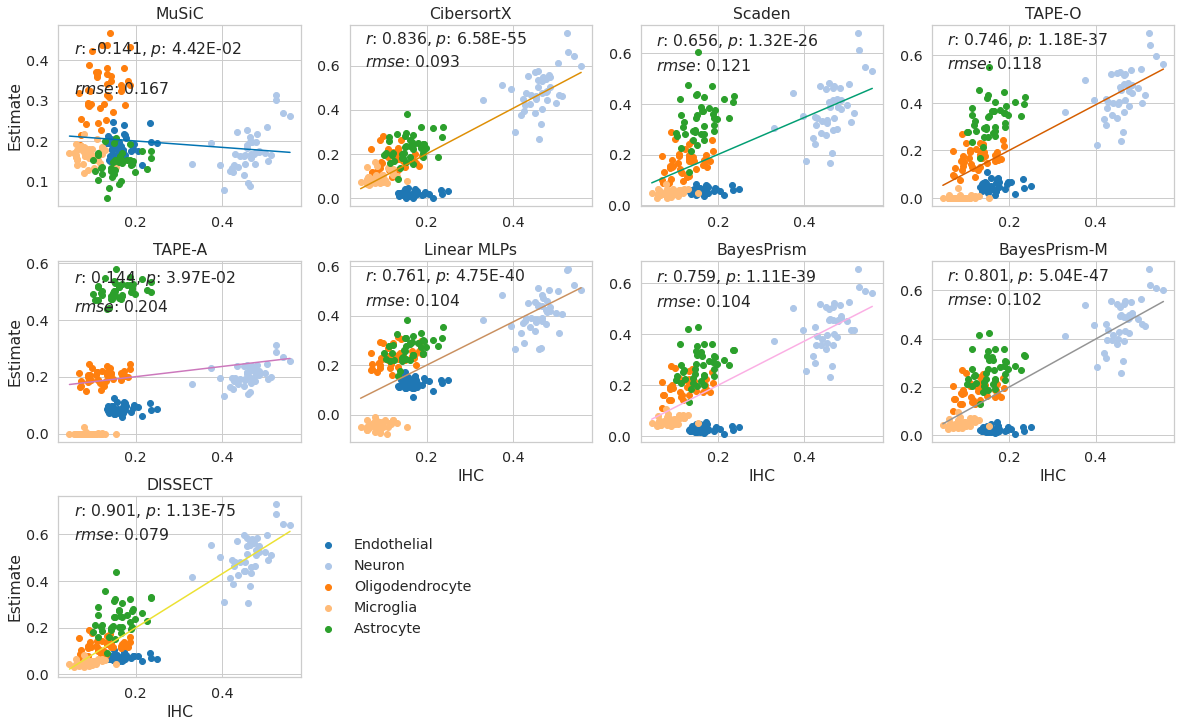

In [64]:
df_ihc = df_ihc.loc[common]
df_cor = pd.DataFrame(index=list(df_results_dict.keys()), columns=df_ihc.columns)
df_jsd = pd.DataFrame(index=list(df_results_dict.keys()), columns=df_ihc.index)
df_rmse = pd.DataFrame(index=list(df_results_dict.keys()), columns=df_ihc.columns)

i = 1

plt.figure(figsize=(20,12))
for key in df_results_dict:
    df_results_dict[key].index = df_results_dict[key].index.astype(str)
    df_results_dict[key] = df_results_dict[key].loc[common]
    df_results_dict[key]["Neuron"] = df_results_dict[key]["Excitatory"] + df_results_dict[key]["Inhibitory"]
    df_results_dict[key] = df_results_dict[key][df_ihc.columns]
    df_results_dict[key] = df_results_dict[key].div(df_results_dict[key].sum(1),0)
    # For evaluation, normalize fractions to sum to 1 over cell types present in IHC.
    
    ax = plt.subplot(nrows, ncols, i)
    for col in df_ihc.columns:
        x, y = df_ihc[col], df_results_dict[key][col]
        df_cor.loc[key, col] = np.corrcoef(x, y)[0,1]
        df_rmse.loc[key, col] = mse(x, y, squared=False)
        
        if i==df_jsd.shape[0]:
            plt.scatter(x, y, color=celltype_colors_dict[col], label=col)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
        else:
            plt.scatter(x, y, color=celltype_colors_dict[col])
            
    if i>ncols and i!=5: 
        plt.xlabel("IHC")
    if i in [1,ncols+1,9]:
        plt.ylabel("Estimate")
        
    x, y = np.array(df_ihc).reshape(-1), np.array(df_results_dict[key]).reshape(-1)
    r, p = round(pearsonr(x, y)[0], 3), pearsonr(x, y)[1]
    rmse = round(mse(x, y, squared=False),3)
    
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=colors_dict[key])
    
    x, y = x.min()+ 0.01, y.max()-0.05
    plt.text(x, y, r"${}$".format("r") + ": {}, ".format(round(r, 3)) + \
             r"${}$".format("p") + ": {}".format("%.2E"%(Decimal(p))))
    plt.text(x, y-0.1, r"${}$".format("rmse") + ": {}".format(rmse))
    
    for sample in df_ihc.index:
        x, y = df_ihc.T[sample].tolist(), df_results_dict[key].T[sample].tolist()
        df_jsd.loc[key, sample] = jsd(x, y)
         
    plt.title(key)
    
    i+=1
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig(os.path.join(savedir, "3C_Extended_data_fig_2_rosmap.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(savedir, "3C_Extended_data_fig_2_rosmap.png"), bbox_inches="tight", dpi=300)